<a href="https://colab.research.google.com/github/Victorlouisdg/simulators/blob/main/implicit_spring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import scipy
import scipy.linalg
from IPython.display import HTML
import matplotlib.pyplot as plt
from matplotlib import animation, rc
rc('animation', html='jshtml')
np.set_printoptions(precision=3, suppress=True)

In [2]:
x0 = np.array([0.0, 0.0, 0.0])
x1 = np.array([1.0, 0.0, 0.0])
positions = [x0, x1]

v0 = np.zeros(3)
v1 = np.zeros(3)
velocities = [v0, v1]

masses = [1.0, 1.0]
inverted_masses = [0.0, 1.0]

M_inv = np.zeros((6,6))
for i in range(6):
    j = 0 if i < 3 else 1
    M_inv[i, i] = inverted_masses[j]

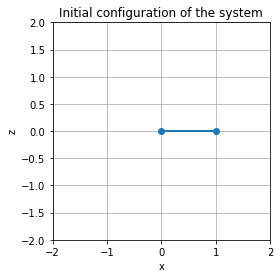

In [3]:
positions = np.vstack([x0, x1])
x, y, z = np.transpose(positions)  # Reads the x and y columns

fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal', xlim=(-2, 2), ylim=(-2, 2))
ax.grid()
ax.set_title('Initial configuration of the system')
ax.set_xlabel('x')
ax.set_ylabel('z')
ax.plot(x, z, 'o-', lw=2);

In [4]:
# Physical constants
m = 0.1        # kg
k = 500000        # N / m
rest_length = 1.0   # m
g = 9.80665    # m/s^2
ag = np.array([0.0, 0.0, -g])  # acceleration due to gravity

dt = 0.01
forces = [np.zeros(3), np.zeros(3)]

force_derivatives = [[np.zeros((3,3)), np.zeros((3,3))], 
                     [np.zeros((3,3)), np.zeros((3,3))]]


timesteps = 500

In [ ]:
def spring_force(x0, x1, k, rest_length):
    spring = x1 - x0
    length = np.linalg.norm(spring)
    direction = spring / length
    force = k * (length - rest_length) * direction
    return force

def spring_jacobian(x0, x1, k, rest_length):
    spring = x1 - x0
    length = np.linalg.norm(spring)
    direction = spring / length
    spring_outer = np.outer(direction, direction)
    # if (length < rest_length):
    #     force_derivative = -k * spring_outer
    # else:
    force_derivative = -k * (spring_outer + (1 - rest_length / length) * (np.identity(3) - spring_outer))
    return force_derivative

def stretch_force_macklin(xi, xj, ks, r):
    xij = xi - xj
    xij_norm = np.linalg.norm(xij)
    xij_hat = xij / xij_norm
    Fs = - ks * (xij_norm - r) * xij_hat
    return Fs

def stretch_force_jacobian(xi, xj, ks, r):
    xij = xi - xj
    xij_norm = np.linalg.norm(xij)
    xij_hat = xij / xij_norm

    term1 = (1 - r / xij_norm) * (np.identity(3) - np.outer(xij_hat, xij_hat))
    term2 = np.outer(xij_hat, xij_hat)
    dFs_dxi = -ks * (term1 + term2)
    return dFs_dxi

def calculate_forces():
    x0 = positions[0]
    x1 = positions[1]
    # force = spring_force(x0, x1, k, rest_length)
    # force = stretch_force_macklin(x0, x1, k, rest_length)

    
    # forces[0] += force
    # forces[1] -= force


    forces[0] += stretch_force_macklin(x0, x1, k, rest_length)
    forces[1] += stretch_force_macklin(x1, x0, k, rest_length)


    # h = 0.000001
    # print("Finite diff")
    # for m in range(3):
    #     x0_h = x0.copy()
    #     x0_h[m] += h
    #     force_h = spring_force(x0_h, x1, k, rest_length)
    #     force_jacobian_finite_diff = (force_h - force) / h
    #     print(force_jacobian_finite_diff)

    # print("Analytic")
    # force_derivative = spring_jacobian(x0, x1, k, rest_length)
    
    # force_derivative = spring_jacobian(x0, x1, k, rest_length)

    # print(force_derivative)

    # force_derivatives[0][1] += force_derivative
    # force_derivatives[1][0] += force_derivative

    force_derivative = stretch_force_jacobian(x0, x1, k, rest_length)

    force_derivatives[0][0] += force_derivative
    force_derivatives[0][1] -= force_derivative
    force_derivatives[1][0] -= force_derivative
    force_derivatives[1][1] += force_derivative


    # J = df0/dx0, df0/dx1
    #     df1/dx0, df1/dx1 

    # force_derivatives[0][0] += stretch_force_jacobian(x0, x1, k, rest_length)
    # force_derivatives[1][1] += stretch_force_jacobian(x1, x0, k, rest_length)

    # Gravity
    forces[0] += np.array([0.0, 0.0, -masses[0] * g])
    forces[1] += np.array([0.0, 0.0, -masses[1] * g])


def integrate_explicit():
    for i in range(2):
        x = positions[i]
        v = velocities[i]
        force = forces[i]
        m_inv = inverted_masses[i]

        a = force * m_inv

        if i == 0:
            a = np.zeros(3)

        v += a * dt
        x += v * dt

        positions[i] = x
        velocities[i] = v

def integrate_implicit():
    h = dt
    f0 = np.zeros((6,1))
    v0 = np.zeros((6,1))

    for i in range(2):
        f0[3*i] = forces[i][0]
        f0[3*i+1] = forces[i][1]
        f0[3*i+2] = forces[i][2]
        v0[3*i] = velocities[i][0]
        v0[3*i+1] = velocities[i][1]
        v0[3*i+2] = velocities[i][2]

    I = np.identity(6)

    dfdx = np.zeros((6,6))
    for i in range(2):
        for j in range(2):
            dfdx[3*i:3*i+3, 3*j:3*j+3] = force_derivatives[i][j]
    print(dfdx)


    A = I - (h ** 2) * M_inv @ dfdx
    b = h * M_inv @ (f0 + h * dfdx @ v0)

    delta_v = np.linalg.solve(A, b)

    print(delta_v)
    # delta_v = scipy.linalg.solve(A, b)
    # delta_v, _, _, _ = scipy.linalg.lstsq(A, b)

    print("A dv - b ", A @ delta_v - b)
    print(np.allclose(A @ delta_v - b, 0.0))

    delta_v0 = delta_v[0:3].flatten()
    delta_v1 = delta_v[3:6].flatten()

    velocities[0] = velocities[0] + delta_v0
    velocities[1] = velocities[1] + delta_v1

    positions[0] = positions[0] + velocities[0] * dt
    positions[1] = positions[1] + velocities[1] * dt

history = []

for i in range(timesteps):
    forces = [np.zeros(3), np.zeros(3)]
    force_derivatives = [[np.zeros((3,3)), np.zeros((3,3))], 
                        [np.zeros((3,3)), np.zeros((3,3))]]
    calculate_forces()
    integrate_implicit()
    # integrate_explicit()
    history.append(positions.copy())

In [ ]:

def animate_spring(history, dt, fps=50):
    fig = plt.figure()
    ax = fig.add_subplot(111, aspect='equal', autoscale_on=False,
                        xlim=(-2, 2), ylim=(-2, 2))

    plt.close()
    ax.grid()
    ax.set_xlabel('x')
    ax.set_ylabel('z')
    line, = ax.plot([], [], 'o-', lw=2)
    time_text = ax.text(0.02, 0.95, '', transform=ax.transAxes)

    fps_simulation = 1 / dt
    skip = np.floor(fps_simulation / fps).astype(np.int32)
    fps_adjusted = fps_simulation / skip
    print('fps was adjusted to: ', fps_adjusted)


    def init():
        line.set_data([], [])
        time_text.set_text('')
        return (line,)

    def animate(i):
        p = history[i * skip]
        x, y, z = np.transpose(p)
        line.set_data(x, z)
        time_text.set_text('time = %.1f' % (i*dt*skip))
        return line, time_text
    

    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                frames=len(history)//skip, interval=1000*dt*skip, blit=True)

    return anim

animate_spring(history, dt)